In [1]:
%load_ext autoreload
%autoreload 2

from torch.utils.data import DataLoader, Dataset
import torch

import sys
sys.path.append('../')
import os

from cont_speech_experiment import ContinuousSpeechExperiment, ClasswiseDataset
from nupic.research.support import parse_config
from correlation_metrics import register_act, plot_metrics

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def train_loop(experiment):
    accs = [] # test loss
    ent = [] # entropy
    class_acc = []
    t_acc = []
    grads = []

    np.random.seed(np.random.randint(0,100))
    train_labels = np.reshape(np.random.permutation(np.arange(1,11)), (5,2))

    epochs = 1
    indices = []

    for label in train_labels:
        print("training on class {}".format(label))

        indices = np.hstack([0,np.delete(train_labels,np.where(train_labels==label)[0],axis=0).flatten()])

        for epoch in range(epochs):
            print("training: epoch {}".format(epoch+1))
            experiment.train(epoch, label, indices)   

            mt = experiment.test()
            t_acc.append(mt["mean_accuracy"])

        ct = [experiment.test_class(k)["mean_accuracy"] for k in range(1,11)]
        class_acc.append(ct)

        t = experiment.test()
        print("Mean accuracy: {}".format(t["mean_accuracy"]))
        accs.append(t["mean_accuracy"])
        ent.append(np.round(t["entropy"]))

    offdiag_corrs, diag_corrs, offdiag_dotprods, diag_dotprods = register_act(experiment)
        
    return offdiag_corrs, diag_corrs, offdiag_dotprods, diag_dotprods

In [24]:
data_dir = "/home/ec2-user/nta/data/data_classes/"
test_dir = "/home/ec2-user/nta/data/"
config_file = "../experiments.cfg"

odcorrs = []
dcorrs = []
oddotproducts = []
ddotproducts = []

sequential = True

cnn_weight_sparsities = [(1.,1.), (0.5, 0.2)]
linear_weight_sparsities = [(1.,), (0.1,)]

cnn_percent_on = [(0.095, 0.125), (1., 1.)]
linear_percent_on = [(0.1,), (1.,)]

for i in range(2):
    for j in range(2):
        config_init = parse_config(config_file)
        exp = "sparseCNN2"
        config = config_init[exp]
        config["name"] = exp
        config["seed"] = np.random.randint(0,200)
        config["data_dir"] = data_dir
        config["batch_size"] = 32
        config["num_classes"] = 11

        config["cnn_weight_sparsity"] = cnn_weight_sparsities[i]
        config["weight_sparsity"] = linear_weight_sparsities[i]
        config["cnn_percent_on"] = cnn_percent_on[j]
        config["linear_percent_on"] = linear_percent_on[j]

        config["freeze_params"] = [] #"output"

        experiment = ContinuousSpeechExperiment(config=config)
        if sequential:    
            offdiag_corrs, diag_corrs, offdiag_dotprods, diag_dotprods = train_loop(experiment)
        else:
            for epoch in range(3):
                experiment.train_entire_dataset(epoch)
            t = experiment.test()
            print("Mean accuracy: {}".format(t["mean_accuracy"]))

            offdiag_corrs, diag_corrs, offdiag_dotprods, diag_dotprods = register_act(experiment)

        odcorrs.append(offdiag_corrs)
        dcorrs.append(diag_corrs)
        oddotproducts.append(offdiag_dotprods)
        ddotproducts.append(diag_dotprods)
        
print("dense + k_winner, dense + relu, sparse + k_winner, sparse + relu")


model on GPU
Creating optimizer with learning rate= 0.01
training on class [3 7]
training: epoch 1
Mean accuracy: 19.788401253918494
training on class [2 4]
training: epoch 1
Mean accuracy: 20.023510971786834
training on class [8 1]
training: epoch 1
Mean accuracy: 18.96551724137931
training on class [10  5]
training: epoch 1
Mean accuracy: 19.905956112852667
training on class [6 9]
training: epoch 1
Mean accuracy: 20.29780564263323
model on GPU
Creating optimizer with learning rate= 0.01
training on class [8 2]
training: epoch 1
Mean accuracy: 17.946708463949843
training on class [9 6]
training: epoch 1
Mean accuracy: 20.4153605015674
training on class [1 3]
training: epoch 1
Mean accuracy: 19.788401253918494
training on class [ 7 10]
training: epoch 1
Mean accuracy: 19.5141065830721
training on class [5 4]
training: epoch 1
Mean accuracy: 20.219435736677116
model on GPU
Creating optimizer with learning rate= 0.01
training on class [9 2]
training: epoch 1
Mean accuracy: 19.51410658307

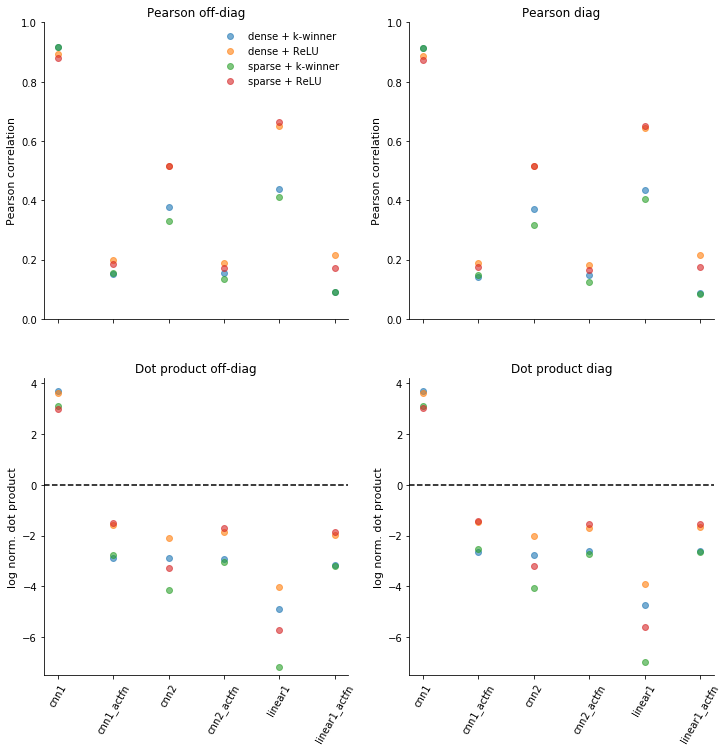

In [25]:
metrics = [odcorrs, dcorrs, oddotproducts, ddotproducts]
plot_metrics(metrics, legend_=["dense + k-winner", "dense + ReLU", "sparse + k-winner", "sparse + ReLU"])
plt.savefig("../plots/corr_quantification_kwinner_relu_allconds_sequential.pdf")

In [51]:
v1 = []
for j in range(10):
    a = np.zeros((32*64))
    inds = np.random.randint(a.size, size=int(a.size / 2))
    a[inds] = 1.
    v1.append(a.reshape(32,64))

In [52]:
v2 = []
for j in range(10):
    b = np.zeros((32*64))
    inds = np.random.randint(b.size, size=int(b.size / 2))
    b[inds] = 1.
    v2.append(b.reshape(32,64))

In [153]:
def random_dotprods(m,n,sparsity=0.1, iters=100):

    v1 = []
    for j in range(10):
        a = np.zeros((m*n))
        inds = np.random.randint(a.size, size=int(sparsity*a.size))
        a[inds] = 1.
        v1.append(a.reshape(m,n) + 1e-5 + 1e-7*np.random.randn(m,n))
        iu = np.triu_indices(10,1)

    def get_dotprod():
        dot_mat = np.zeros((10,10))
        corr_mat = np.zeros_like(dot_mat)
        for i in range(10):
            for j in range(10):
                corr_mat[i,j] = np.mean(np.corrcoef(v1[i],
                                                   v1[j])[iu])
                dot_mat[i,j] = np.mean([np.dot(v1[i][x,:],
                                               v1[j][y,:]) / n
                                      for x in range(m)
                                        for y in range(m)
                                       ])
        return dot_mat, corr_mat
    
    dp_ = [get_dotprod()[k][iu].flatten().mean() for k in range(2) for i in range(iters)]
    dp_mean, cc_mean = np.mean(dp_[::2]), np.mean(dp_[1::2])

    
    return dp_mean, cc_mean

In [ ]:
dps = [random_dotprods(32,64, sparsity=k, iters=10) for k in np.arange(0.0,1.0, 0.05)]

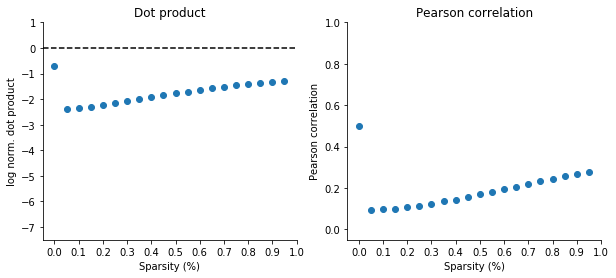

In [140]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(np.arange(0.00,1.0, 0.05), [np.log(k[0]) for k in dps], 'o')
ax[0].set_xticks(np.arange(0.0, 1.1, 0.1));
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)
ax[0].set_title("Dot product")
ax[0].set_xlabel("Sparsity (%)")
ax[0].set_ylabel("log norm. dot product")
ax[0].axhline([0], color="k", linestyle="--")
ax[0].set_ylim((-7.5, 1.))

ax[1].plot(np.arange(0.00,1.0, 0.05), [k[1] for k in dps], 'o')
ax[1].set_xticks(np.arange(0.0, 1.1, 0.1));
ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)
ax[1].set_title("Pearson correlation")
ax[1].set_xlabel("Sparsity (%)")
ax[1].set_ylabel("Pearson correlation")
ax[1].set_ylim((-0.05, 1.))

plt.savefig("../plots/random_sparse_vectors_corr_metrics_32_64.pdf")

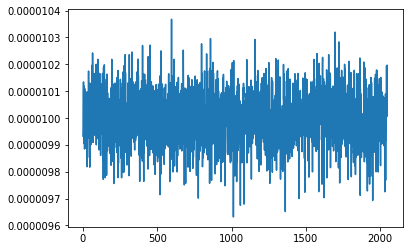

In [150]:
plt.plot(1e-5 + 1e-7*np.random.randn(a.size))